In [1]:
from datetime import datetime

import corner
import emcee
import matplotlib as plt
import numpy as np

# import itm.likelihood
import itm.utils
from itm.posterior_calculator import PosteriorCalculator

results/20220319_211000
MCMC
walkers:  32
Loading local_hubble data
Loading cosmic_chronometers data
Loading jla data
Loading bao_compilation data


 20%|██        | 100/500 [00:40<02:34,  2.58it/s]

[10.76106076 10.43196198  8.87911156  8.55748746]


 40%|████      | 200/500 [01:20<01:59,  2.52it/s]

[21.90885764 21.38488027 18.20421583 14.55426381]


 60%|██████    | 300/500 [01:59<01:19,  2.50it/s]

[27.51711211 27.4714903  22.52370679 19.39297494]


 80%|████████  | 400/500 [02:39<00:38,  2.57it/s]

[29.44497374 29.02798359 26.85269536 23.21438929]


100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


[30.21653306 30.02091028 28.56114287 25.56464115]
(16000, 4)
CPU times: user 2min 56s, sys: 3.7 s, total: 3min
Wall time: 3min 19s


Text(0.5, 0.98, 'walkers: 32 steps: 500')

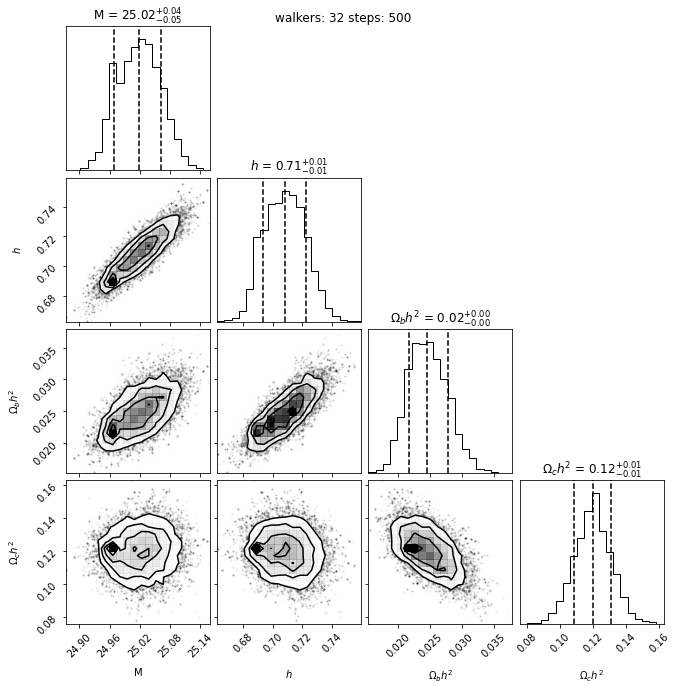

In [2]:
%%time
 
config_params = itm.utils.load_config("/Users/fabio/code/fchibana/tachyons/config.yaml")

# print(config_params)

mcmc_params = config_params["mcmc_params"]
experiments = ['local_hubble', 'cosmic_chronometers', 'jla', 'bao_compilation']


p0 = [24.96, 0.69, 0.022, 0.12]         # initial guess 
ndim = len(p0)  
nwalkers =  mcmc_params["n_walkers"] 

out_name = "results/" + datetime.now().strftime("%Y%m%d_%H%M%S")
print(out_name)

backend = emcee.backends.HDFBackend(out_name + ".h5")
backend.reset(nwalkers, ndim)


# # MCMC =============================================================================================

print("MCMC")
print("walkers: ", nwalkers)



# # initialize sampler
# sampler = emcee.EnsembleSampler(nwalkers, ndim, itm.likelihood.lnprob, backend=backend)

prob = PosteriorCalculator(experiments=experiments)
sampler = emcee.EnsembleSampler(nwalkers, ndim, prob.ln_posterior, backend=backend)

# # condicoes iniciais dos walkers dentro da bola de centro p1_0
pos = [p0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

max_n = 500

# # We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# # This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    steps = sampler.iteration
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    print(tau)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau
    


# # Analysis ===========================================================================================

# tau = sampler.get_autocorr_time()
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
# flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)

flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

fig = corner.corner(flat_samples,
                    labels=["M", "$h$",
                            "$\Omega_{b} h^2$", "$\Omega_{c} h^2$"],
                    quantiles=(0.16, 0.5, 0.84), show_titles=True,
                    title_kwargs={"fontsize": 12})
fig.suptitle('walkers: %s steps: %s' % (nwalkers, steps))
# fig = corner.corner(flat_samples)
# fig.show()

# fig.savefig(out_name + ".png")
